### Author: Subham Moda

Importing the required libraries.

In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import spacy
import seaborn as sns
import re
import gensim
from gensim.models import Word2Vec
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.cluster import KMeansClusterer,cosine_distance,euclidean_distance
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import time

In [2]:
def remove_stopwords(docs):
    
    token = [word for word in docs if word not in stopwords]
    return token

Importing the data from csv created earlier and formatting the dataframe.

In [53]:
data = pd.read_csv('movie_data.csv')
data.drop(columns={'Unnamed: 0', 'rating_sentiment'}, inplace=True)
data['tokenized_reviews'] = data['tokenized_reviews'].apply(eval)
data.sample(10)

,movie_title,review_title,review,rating,sentiment_label,tokenized_reviews
6624,The Adjustment Bureau (2011),Crappy trailer,"I really liked this movie, but I can't believe...",1,0,"[really, like, this, movie, but, can, not, bel..."
1723,Inception (2010),Dickian dreams,"Say what you want of Nolan, the new populist d...",8,1,"[say, what, you, want, of, Nolan, the, new, po..."
3420,The Parent Trap (1998),Watched this at least 20 times,"No joke, there is no movie I've seen more time...",7,1,"[no, joke, there, be, no, movie, ve, see, more..."
3737,Cocaine Bear (2023),"For better or worse, it's the exact movie you...",Cocaine Bear offers little beyond the trailers...,6,1,"[Cocaine, Bear, offer, little, beyond, the, tr..."
6711,Life of Pi (2012),"A Boy, a Tiger, and God","Within the first ten minutes, the titular prot...",8,1,"[within, the, first, ten, minute, the, titular..."
7720,Grown Ups (I) (2010),substandard for Adam Sandler,"This movie had some laughs, but it was pretty ...",5,0,"[this, movie, have, some, laugh, but, it, be, ..."
8773,You Don't Mess with the Zohan (2008),Don't watch this if you want to laugh,The story line was crappy as hell. I felt like...,1,0,"[the, story, line, be, crappy, as, hell, feel,..."
1751,Inception (2010),The conception of Inception is a deception,I must have seen a different film than all tho...,6,1,"[must, have, see, different, film, than, all, ..."
8731,You Don't Mess with the Zohan (2008),"If you need cheering up, this shocking film w...",Why do I listen to what's top 3 on Netflix!!! ...,7,1,"[why, do, listen, to, what, be, top, on, Netfl..."
2088,Easy A (2010),More gossip than Gossip Girl and it's better!,Thank you Emma Stone for helping this movie be...,7,1,"[thank, you, Emma, Stone, for, help, this, mov..."


Selecting the required columns for analysis

In [4]:
review_data = data[['review','tokenized_reviews','rating','sentiment_label']]
review_data.sample(5)

,review,tokenized_reviews,rating,sentiment_label
5930,This film was never going to be a masterpiece ...,"[this, film, be, never, go, to, be, masterpiec...",6,1
6476,Sometimes a flawed and somewhat predictable mo...,"[sometimes, flawed, and, somewhat, predictable...",7,1
3935,"This movie is utterly dreadful. However, I did...","[this, movie, be, utterly, dreadful, however, ...",1,0
2153,"THE FOUNDER (2016) ***1/2 Michael Keaton, Nick...","[the, FOUNDER, 2016, 1/2, Michael, Keaton, Nic...",9,1
2867,"Back in 2008 (or 2009, who cares?) We got our ...","[back, in, 2008, or, 2009, who, care, we, get,...",10,1


Adjusting the words present in stopwords

In [9]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.remove('no')
stopwords.remove('not')
stopwords.remove('nor')
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', '

## VADER Sentiment on plain text reviews

In [7]:
vader_data = review_data.copy()
vader_data.sample(5)

,review,tokenized_reviews,rating,sentiment_label
5026,I do occasionally read something from the best...,"[do, occasionally, read, something, from, the,...",6,1
1773,'Home Alone' has succeeded in establishing its...,"[home, alone, have, succeed, in, establish, it...",10,1
1682,This movie was (and is) beloved by everyone so...,"[this, movie, be, and, be, belove, by, everyon...",6,1
803,"Before i start my review, i'd like to note tha...","[before, start, my, review, would, like, to, n...",7,1
4206,I watched the first hour and a half of this mo...,"[watch, the, first, hour, and, half, of, this,...",10,1


Running vader sentiment algorithm and predicting based on the compound value of the text, if >0 sentiment is considered to be positive, else negative.

In [8]:
pred_sentiment = []
sia = SentimentIntensityAnalyzer()
for x in vader_data['review']:
    score = sia.polarity_scores(x)['compound']
    if score > 0:
        pred_sentiment.append(1)
    else:
        pred_sentiment.append(0)
vader_data['pred_sentiment'] = pred_sentiment

Classification report for the vader sentiment analysis.

In [9]:
print(classification_report(vader_data['sentiment_label'], vader_data['pred_sentiment']))

              precision    recall  f1-score   support

           0       0.66      0.46      0.54      2873
           1       0.80      0.90      0.85      6792

    accuracy                           0.77      9665
   macro avg       0.73      0.68      0.69      9665
weighted avg       0.76      0.77      0.76      9665



Confusion matrix for vader sentiment analysis.

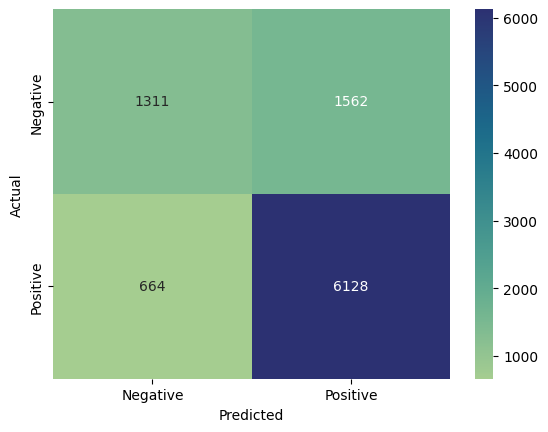

In [10]:
definitions = ['Negative','Positive']
con_matrix = confusion_matrix(vader_data['sentiment_label'], vader_data['pred_sentiment'])
sns.heatmap(con_matrix, annot=True, xticklabels=definitions, yticklabels=definitions, fmt=".0f", cmap="crest")
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
plt.show()

## VADER Sentiment on tokenized text reviews

In [12]:
vader_data = review_data.copy()
vader_data.sample(5)

,review,tokenized_reviews,rating,sentiment_label
3134,Sky High (2005): Dir: Mike Mitchell / Cast: Mi...,"[Sky, High, 2005, , Dir, Mike, Mitchell, Cast,...",3,0
2221,"Of the many times I have eaten there, I never ...","[of, the, many, time, have, eat, there, never,...",10,1
1397,5/10 - stunning cinematography and some massiv...,"[5/10, stunning, cinematography, and, some, ma...",5,0
8258,This is a very funny movie and movies like tha...,"[this, be, very, funny, movie, and, movie, lik...",8,1
8726,In The Mask a demonic visage gets released upo...,"[in, the, Mask, demonic, visage, gets, release...",6,1


Running vader sentiment algorithm and predicting based on the compound value of the tokens, if >0 sentiment is considered to be positive, else negative.

In [13]:
pred_sentiment = []
sia = SentimentIntensityAnalyzer()
for x in vader_data['tokenized_reviews']:
    score = sia.polarity_scores(' '.join(x))['compound']
    if score > 0:
        pred_sentiment.append(1)
    else:
        pred_sentiment.append(0)
vader_data['pred_sentiment'] = pred_sentiment

Classification report for the vader sentiment analysis.

In [14]:
print(classification_report(vader_data['sentiment_label'], vader_data['pred_sentiment']))

              precision    recall  f1-score   support

           0       0.66      0.46      0.54      2873
           1       0.80      0.90      0.85      6792

    accuracy                           0.77      9665
   macro avg       0.73      0.68      0.69      9665
weighted avg       0.76      0.77      0.76      9665



Confusion matrix for vader sentiment analysis.

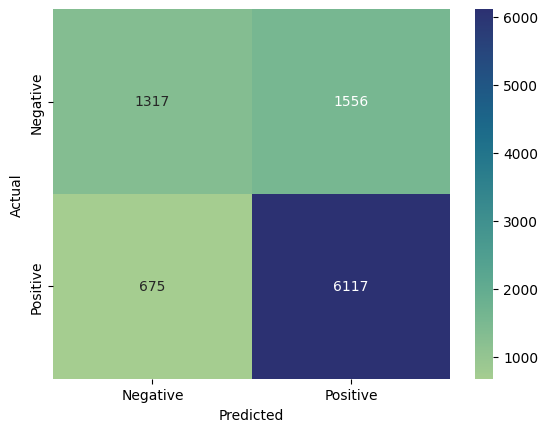

In [15]:
definitions = ['Negative','Positive']
con_matrix = confusion_matrix(vader_data['sentiment_label'], vader_data['pred_sentiment'])
sns.heatmap(con_matrix, annot=True, xticklabels=definitions, yticklabels=definitions, fmt=".0f", cmap="crest")
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
plt.show()

## VADER Sentiment on tokenized text reviews without stopwords

In [220]:
vader_data = review_data.copy()
vader_data.sample(5)

,review,tokenized_reviews,rating,sentiment_label
2259,Lots of tongue in cheek. Some great characteri...,"[lot, of, tongue, in, cheek, some, great, char...",9,1
3397,I adore the original starring Hayley Mills. It...,"[adore, the, original, star, Hayley, Mills, it...",8,1
5374,The real critics were a bit hard on this one. ...,"[the, real, critic, be, bit, hard, on, this, o...",7,1
3235,(Correction of a reference I made in my review...,"[correction, of, reference, make, in, my, revi...",10,1
8720,This was on TV last night and as I am a fan of...,"[this, be, on, tv, last, night, and, as, be, f...",7,1


In [221]:
vader_data['tokenized_reviews'] = vader_data['tokenized_reviews'].apply(remove_stopwords)

In [222]:
pred_sentiment = []
sia = SentimentIntensityAnalyzer()
for x in vader_data['tokenized_reviews']:
    score = sia.polarity_scores(' '.join(x))['compound']
    if score > 0:
        pred_sentiment.append(1)
    else:
        pred_sentiment.append(0)
vader_data['pred_sentiment'] = pred_sentiment

In [223]:
print(classification_report(vader_data['sentiment_label'], vader_data['pred_sentiment']))

              precision    recall  f1-score   support

           0       0.63      0.44      0.52      2873
           1       0.79      0.89      0.84      6792

    accuracy                           0.76      9665
   macro avg       0.71      0.66      0.68      9665
weighted avg       0.74      0.76      0.74      9665



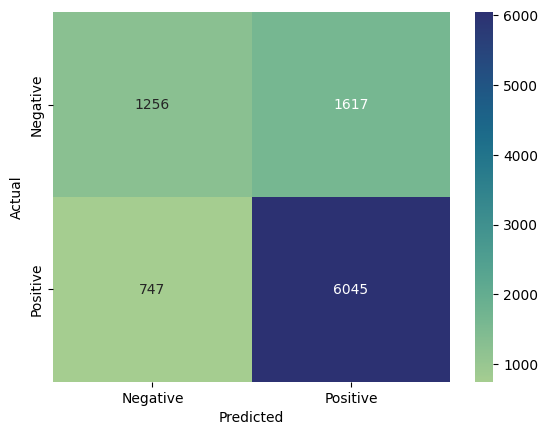

In [224]:
definitions = ['Negative','Positive']
con_matrix = confusion_matrix(vader_data['sentiment_label'], vader_data['pred_sentiment'])
sns.heatmap(con_matrix, annot=True, xticklabels=definitions, yticklabels=definitions, fmt=".0f", cmap="crest")
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
plt.show()

## Sentiment Analysis based on gensim similarity

Created the required functions for tokenizing the reviews and calculating cosine similarities between positive/negative words and tokens from reviews. Finally based on the difference in similarity we can predict if the sentiment in the review is positive or negative.

In [40]:
def calculate_similarity_score(key_vectors, target_tokens, doc):
    
    target_token = [token for token in target_tokens if token in key_vectors.key_to_index]

    doc_token = [token for token in doc if token in key_vectors.key_to_index]
    
    similarity_score = key_vectors.n_similarity(target_tokens, doc_token)
    
    return similarity_score

def sentiment_analysis(key_vectors, positive_tokens, negative_tokens, docs):
    
    positive_score = docs.apply(lambda x: calculate_similarity_score(key_vectors=key_vectors, 
                                                                 target_tokens=positive_tokens, 
                                                                 doc=x))

    negative_score = docs.apply(lambda x: calculate_similarity_score(key_vectors=key_vectors, 
                                                                 target_tokens=negative_tokens, 
                                                                 doc=x))

    semantic_sentiment_score = positive_score - negative_score
    
    semantic_sentiment_polarity = semantic_sentiment_score.apply(lambda x: 1 if (x > 0) else 0)
                                          
    return positive_score, negative_score, semantic_sentiment_score, semantic_sentiment_polarity
    

## Implementing the model on tokenized reviews using polarity dataset

In [41]:
gensim_data = review_data.copy()
gensim_data.head()

,review,tokenized_reviews,rating,sentiment_label
0,"Wow. The first Top Gun is a classic, and as we...","[wow, the, first, Top, Gun, be, classic, and, ...",10,1
1,If you were a late teen or in your early twent...,"[if, you, be, late, teen, or, in, your, early,...",10,1
2,In one of the more memorable lines in the orig...,"[in, one, of, the, more, memorable, line, in, ...",10,1
3,This is one sequel that looked like it would n...,"[this, be, one, sequel, that, look, like, it, ...",10,1
4,"I was reluctantly dragged into the theater, th...","[be, reluctantly, drag, into, the, theater, th...",10,1


In [50]:
w2v_model = Word2Vec(gensim_data['tokenized_reviews'],workers=4,vector_size=300,window=5,min_count=5)

In [51]:
positive = pd.read_csv('positive-words.txt', header=None)
negative = pd.read_csv('negative-words.txt', header=None)

positive_word_li = list(positive[0])
negative_word_li = list(negative[0])

In [52]:
semantic_scores = sentiment_analysis(w2v_model.wv, positive_word_li, negative_word_li, gensim_data['tokenized_reviews'])

gensim_data['PSS'] = semantic_scores[0] 
gensim_data['NSS'] = semantic_scores[1] 
gensim_data['semantic_sentiment_score'] = semantic_scores[2] 
gensim_data['semantic_sentiment'] = semantic_scores[3]

In [53]:
print(classification_report(gensim_data['sentiment_label'], gensim_data['semantic_sentiment']))

              precision    recall  f1-score   support

           0       0.12      0.00      0.00      2873
           1       0.70      1.00      0.82      6792

    accuracy                           0.70      9665
   macro avg       0.41      0.50      0.41      9665
weighted avg       0.53      0.70      0.58      9665



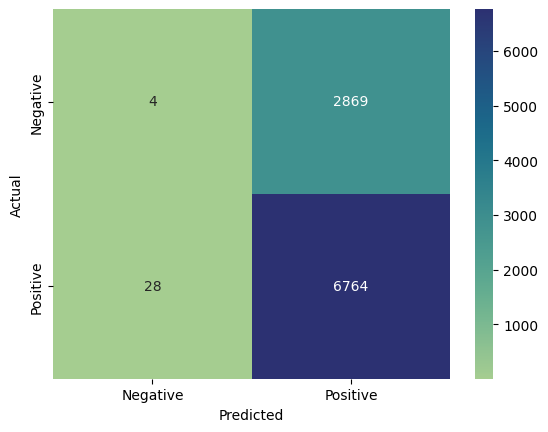

In [54]:
definitions = ['Negative','Positive']
con_matrix = confusion_matrix(gensim_data['sentiment_label'], gensim_data['semantic_sentiment'])
sns.heatmap(con_matrix, annot=True, xticklabels=definitions, yticklabels=definitions, fmt=".0f", cmap="crest")
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
plt.show()

In [53]:
gensim_data = review_data.copy()
gensim_data.head()

,review,tokenized_reviews,rating,sentiment_label
0,"Wow. The first Top Gun is a classic, and as we...","[wow, the, first, Top, Gun, be, classic, and, ...",10,1
1,If you were a late teen or in your early twent...,"[if, you, be, late, teen, or, in, your, early,...",10,1
2,In one of the more memorable lines in the orig...,"[in, one, of, the, more, memorable, line, in, ...",10,1
3,This is one sequel that looked like it would n...,"[this, be, one, sequel, that, look, like, it, ...",10,1
4,"I was reluctantly dragged into the theater, th...","[be, reluctantly, drag, into, the, theater, th...",10,1


Trying to select the best parameters to tune the gensim model, trying various combinations of vector sizes, windows and minimum word length values.

In [178]:
vector_sizes = range(100,300,50)
windows = range(3,13,2)
min_counts = range(2,5)
best_model = None
best_vector = None
best_window = None
best_count = None
f1 = 0
for size in vector_sizes:
    for window in windows:
        for min_count in min_counts:
            w2v_model = Word2Vec(gensim_data['tokenized_reviews'],workers=4,vector_size=size,window=window,min_count=min_count)
            semantic_scores = sentiment_analysis(w2v_model.wv, positive_word_li, negative_word_li, gensim_data['tokenized_reviews'])
            gensim_data['semantic_sentiment'] = semantic_scores[3]
            temp_score = f1_score(gensim_data['sentiment_label'], gensim_data['semantic_sentiment'], average='weighted')
            if temp_score > f1:
                f1 = temp_score
                best_model = w2v_model
                best_vector = size
                best_window = window
                best_count = min_count
print('Best Vector Size: ', best_vector)
print('Best Window Size: ', best_window)
print('Best min_count: ', best_count)
semantic_scores = sentiment_analysis(best_model.wv, positive_word_li, negative_word_li, gensim_data['tokenized_reviews'])
gensim_data['semantic_sentiment'] = semantic_scores[3]
print(f1_score(gensim_data['sentiment_label'], gensim_data['semantic_sentiment'], average='weighted'))

Best Vector Size:  150
Best Window Size:  11
Best min_count:  4
0.6620551367217852


In [46]:
w2v_model = Word2Vec(gensim_data['tokenized_reviews'],workers=4,vector_size=150,window=11,min_count=4)
semantic_scores = sentiment_analysis(w2v_model.wv, positive_word_li, negative_word_li, gensim_data['tokenized_reviews'])
gensim_data['semantic_sentiment'] = semantic_scores[3]
print(classification_report(gensim_data['sentiment_label'], gensim_data['semantic_sentiment']))

              precision    recall  f1-score   support

           0       0.42      0.04      0.07      2873
           1       0.71      0.98      0.82      6792

    accuracy                           0.70      9665
   macro avg       0.57      0.51      0.44      9665
weighted avg       0.62      0.70      0.60      9665



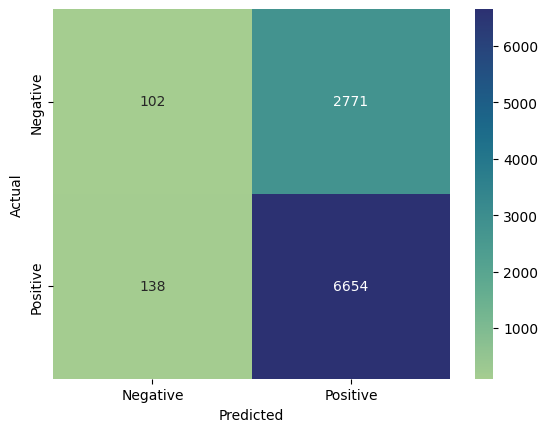

In [47]:
definitions = ['Negative','Positive']
con_matrix = confusion_matrix(gensim_data['sentiment_label'], gensim_data['semantic_sentiment'])
sns.heatmap(con_matrix, annot=True, xticklabels=definitions, yticklabels=definitions, fmt=".0f", cmap="crest")
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
plt.show()

In [55]:
gensim_data = review_data.copy()
gensim_data.sample(5)

,review,tokenized_reviews,rating,sentiment_label
2613,Reuben (Ben Stiller) is a straitlaced risk man...,"[Reuben, Ben, Stiller, be, straitlace, risk, m...",2,0
8338,Night at the Musuem stars the very funny Ben S...,"[night, at, the, Musuem, star, the, very, funn...",7,1
2122,THE FOUNDER is a film much like Fincher's THE ...,"[the, FOUNDER, be, film, much, like, Fincher, ...",10,1
4725,I went into Ratatouille with huge expectations...,"[go, into, Ratatouille, with, huge, expectatio...",6,1
5384,"I'm not really a fan of Christian Bale, but th...","[be, not, really, fan, of, Christian, Bale, bu...",10,1


In [56]:
gensim_data['tokenized_reviews'] = gensim_data['tokenized_reviews'].apply(remove_stopwords)

In [60]:
w2v_model = Word2Vec(gensim_data['tokenized_reviews'],workers=4,vector_size=150,window=11,min_count=4)

In [61]:
semantic_scores = sentiment_analysis(w2v_model.wv, positive_word_li, negative_word_li, gensim_data['tokenized_reviews'])

gensim_data['PSS'] = semantic_scores[0] 
gensim_data['NSS'] = semantic_scores[1] 
gensim_data['semantic_sentiment_score'] = semantic_scores[2] 
gensim_data['semantic_sentiment'] = semantic_scores[3]

print(classification_report(gensim_data['sentiment_label'], gensim_data['semantic_sentiment']))

              precision    recall  f1-score   support

           0       0.47      0.21      0.29      2873
           1       0.73      0.90      0.81      6792

    accuracy                           0.70      9665
   macro avg       0.60      0.56      0.55      9665
weighted avg       0.65      0.70      0.65      9665



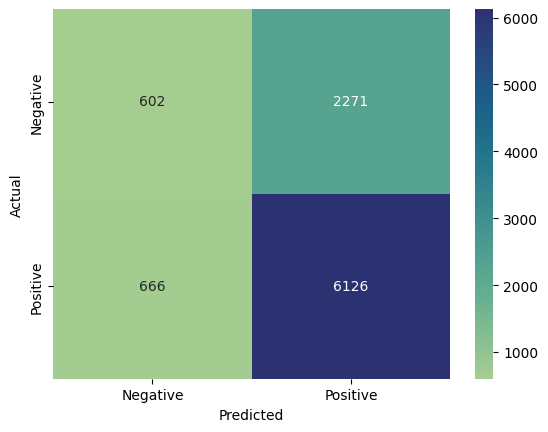

In [62]:
definitions = ['Negative','Positive']
con_matrix = confusion_matrix(gensim_data['sentiment_label'], gensim_data['semantic_sentiment'])
sns.heatmap(con_matrix, annot=True, xticklabels=definitions, yticklabels=definitions, fmt=".0f", cmap="crest")
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
plt.show()

## Implementing the model on tokenized reviews using custom word list

Modifying the default stopwords to remove negating words like no, not, and nor as they play an important role in reviews. For eg: not good, niether entertaining nor watchable, etc.

In [73]:
gensim_data = review_data.copy()
gensim_data.sample(5)

,review,tokenized_reviews,rating,sentiment_label
5962,"The acting was simply amazing, what else could...","[the, acting, be, simply, amazing, what, else,...",10,1
7954,make for a lousy movie. The problem with this ...,"[make, for, lousy, movie, the, problem, with, ...",4,0
982,The first half of hour of this film is very fu...,"[the, first, half, of, hour, of, this, film, b...",4,0
1822,I don't know why I avoided this film. It's a J...,"[do, not, know, why, avoid, this, film, it, be...",10,1
6465,Expect to be in for a jolly good ride if a fil...,"[expect, to, be, in, for, jolly, good, ride, i...",9,1


In [81]:
w2v_model = Word2Vec(gensim_data['tokenized_reviews'],workers=4,vector_size=150,window=11,min_count=4)

We find words from the vocabulary which have close similarity with good, bad and average. We create a list of words from these similar words for positive, negative and neutral emotion.

In [76]:
w2v_model.wv.most_similar('good',topn=20)

[('fine', 0.7033397555351257),
 ('great', 0.6902096271514893),
 ('decent', 0.6446502804756165),
 ('bad', 0.5951171517372131),
 ('perfect', 0.5621051788330078),
 ('fantastic', 0.5584308505058289),
 ('funniest', 0.5573737025260925),
 ('solid', 0.5477094054222107),
 ('amazing', 0.5362098217010498),
 ('wonderful', 0.5360158681869507),
 ('awesome', 0.5230631828308105),
 ('enjoyable', 0.5144273042678833),
 ('cool', 0.5133271813392639),
 ('entertaining', 0.49867281317710876),
 ('brilliant', 0.4907563626766205),
 ('terrible', 0.4900643527507782),
 ('fond', 0.4850315451622009),
 ('terrific', 0.47900304198265076),
 ('definitely', 0.4783366024494171),
 ('nice', 0.47503602504730225)]

In [77]:
w2v_model.wv.most_similar('bad',topn=20)

[('dumb', 0.6489478945732117),
 ('terrible', 0.6083087921142578),
 ('awful', 0.6060541272163391),
 ('good', 0.5951172709465027),
 ('ok', 0.5899317264556885),
 ('stupid', 0.5896429419517517),
 ('poor', 0.5091024041175842),
 ('cool', 0.4907423257827759),
 ('boring', 0.4832514226436615),
 ('horrible', 0.48151567578315735),
 ('weak', 0.4704088568687439),
 ('badly', 0.45335283875465393),
 ('mediocre', 0.45285776257514954),
 ('annoying', 0.4480356276035309),
 ('damn', 0.444418340921402),
 ('dreadful', 0.42467087507247925),
 ('funny', 0.42312154173851013),
 ('yeah', 0.42109379172325134),
 ('honestly', 0.41196611523628235),
 ('okay', 0.4080488681793213)]

In [82]:
positive_word_li = ['good','decent','fine','great','brilliant','perfect','fantastic','nice','excellent','amazing']
#                     'solid','nice','amazing','fantastic','awesome','perfect','wonderful']
negative_word_li = ['terrible','awful','horrible','dumb','poor','stupid','weak','bad','boring','ridiculous']

In [83]:
semantic_scores = sentiment_analysis(w2v_model.wv, positive_word_li, negative_word_li, gensim_data['tokenized_reviews'])
gensim_data['PSS'] = semantic_scores[0] 
gensim_data['NSS'] = semantic_scores[1] 
gensim_data['semantic_sentiment_score'] = semantic_scores[2] 
gensim_data['semantic_sentiment'] = semantic_scores[3]
print(classification_report(gensim_data['sentiment_label'], gensim_data['semantic_sentiment']))

              precision    recall  f1-score   support

           0       0.40      0.91      0.55      2873
           1       0.92      0.42      0.58      6792

    accuracy                           0.57      9665
   macro avg       0.66      0.66      0.57      9665
weighted avg       0.76      0.57      0.57      9665



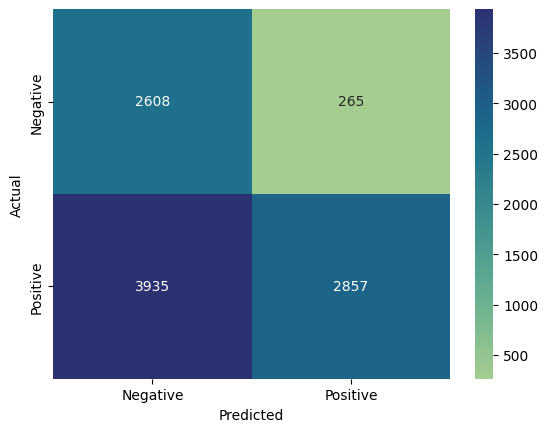

In [84]:
definitions = ['Negative','Positive']
con_matrix = confusion_matrix(gensim_data['sentiment_label'], gensim_data['semantic_sentiment'])
sns.heatmap(con_matrix, annot=True, xticklabels=definitions, yticklabels=definitions, fmt=".0f", cmap="crest")
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
plt.show()

In [ ]:
gensim_data = review_data.copy()
gensim_data.sample(5)

In [185]:
gensim_data['tokenized_reviews'] = gensim_data['tokenized_reviews'].apply(remove_stopwords)

In [186]:
vector_sizes = range(100,300,50)
windows = range(3,13,2)
min_counts = range(2,5)
best_model = None
best_vector = None
best_window = None
best_count = None
f1 = 0
for size in vector_sizes:
    for window in windows:
        for min_count in min_counts:
            w2v_model = Word2Vec(gensim_data['tokenized_reviews'],workers=4,vector_size=size,window=window,min_count=min_count)
            semantic_scores = sentiment_analysis(w2v_model.wv, positive_word_li, negative_word_li, gensim_data['tokenized_reviews'])
            gensim_data['semantic_sentiment'] = semantic_scores[3]
            temp_score = f1_score(gensim_data['sentiment_label'], gensim_data['semantic_sentiment'], average='weighted')
            if temp_score > f1:
                f1 = temp_score
                best_model = w2v_model
                best_vector = size
                best_window = window
                best_count = min_count
print('Best Vector Size: ', best_vector)
print('Best Window Size: ', best_window)
print('Best min_count: ', best_count)
semantic_scores = sentiment_analysis(best_model.wv, positive_word_li, negative_word_li, gensim_data['tokenized_reviews'])
gensim_data['semantic_sentiment'] = semantic_scores[3]
print(f1_score(gensim_data['sentiment_label'], gensim_data['semantic_sentiment'], average='weighted'))

Best Vector Size:  100
Best Window Size:  11
Best min_count:  4
0.6686405108585508


In [187]:
w2v_model = Word2Vec(gensim_data['tokenized_reviews'],workers=4,vector_size=100,window=11,min_count=4)
semantic_scores = sentiment_analysis(w2v_model.wv, positive_word_li, negative_word_li, gensim_data['tokenized_reviews'])
gensim_data['PSS'] = semantic_scores[0] 
gensim_data['NSS'] = semantic_scores[1] 
gensim_data['semantic_sentiment_score'] = semantic_scores[2] 
gensim_data['semantic_sentiment'] = semantic_scores[3]
print(classification_report(gensim_data['sentiment_label'], gensim_data['semantic_sentiment']))

              precision    recall  f1-score   support

           0       0.45      0.88      0.60      2873
           1       0.92      0.55      0.69      6792

    accuracy                           0.65      9665
   macro avg       0.69      0.72      0.65      9665
weighted avg       0.78      0.65      0.66      9665



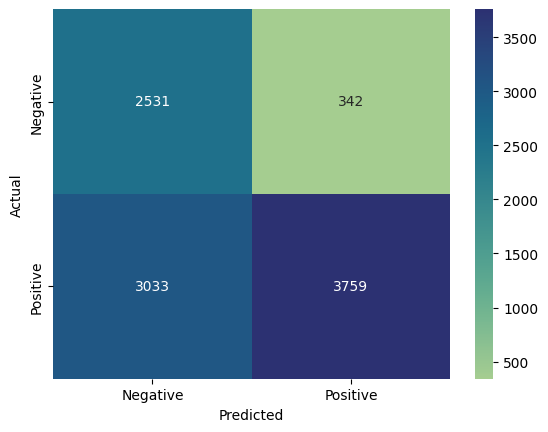

In [188]:
definitions = ['Negative','Positive']
con_matrix = confusion_matrix(gensim_data['sentiment_label'], gensim_data['semantic_sentiment'])
sns.heatmap(con_matrix, annot=True, xticklabels=definitions, yticklabels=definitions, fmt=".0f", cmap="crest")
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
plt.show()

## Kmeans clustering

In [5]:
kmean_data = review_data.copy()
kmean_data.sample(5)

,review,tokenized_reviews,rating,sentiment_label
8245,I have used the IMDb review for years to look ...,"[have, use, the, IMDb, review, for, year, to, ...",1,0
606,"A tragic true story told as generic, mundane a...","[tragic, true, story, tell, as, generic, munda...",2,0
3768,Oh how I was looking forward to a laugh and a ...,"[oh, how, be, look, forward, to, laugh, and, h...",2,0
6867,"Aaron Sorkin is a sort of genius, a word I alm...","[Aaron, Sorkin, be, sort, of, genius, word, al...",10,1
4600,Toy Story is the film that started Pixar Anima...,"[Toy, Story, be, the, film, that, start, Pixar...",10,1


In [6]:
x_train,x_test,y_train,y_test=train_test_split(kmean_data["review"],kmean_data["sentiment_label"],test_size=0.3,random_state=0)

In [7]:
def cluster_kmean(train_text, test_text, test_label, metric = 'Cosine', min_df=5, num=2, repeat=20):
    
    tfidf_vect = TfidfVectorizer(stop_words=stopwords, min_df=min_df, binary=True)
    train = tfidf_vect.fit_transform(train_text)
    test = tfidf_vect.transform(test_text)
    if metric == 'Cosine':
        clusterer = KMeansClusterer(num, cosine_distance, repeats=repeat)
        clusters = clusterer.cluster(train.toarray(), assign_clusters=True)
        predicted = [clusterer.classify(v) for v in test.toarray()]
    else:
        clusterer = KMeansClusterer(num, euclidean_distance, repeats=repeat)
        clusters = clusterer.cluster(train.toarray(), assign_clusters=True)
        predicted = [clusterer.classify(v) for v in test.toarray()]
    
    confusion_df = pd.DataFrame(list(zip(test_label.values, predicted)), columns=['label', 'cluster'])
    cross = pd.crosstab(index=confusion_df.cluster, columns=confusion_df.label)
    cluster = []
    for x in predicted:
        cluster.append(cross.idxmax(axis="columns")[x])
    print(classification_report(y_test, cluster))
    
    definitions = ['Negative','Positive']
    con_matrix = confusion_matrix(y_test, cluster)
    sns.heatmap(con_matrix, annot=True, xticklabels=definitions, yticklabels=definitions, fmt=".0f", cmap="crest")
    plt.xlabel('Predicted') 
    plt.ylabel('Actual') 
    plt.show()

              precision    recall  f1-score   support

           0       0.60      0.58      0.59       572
           1       0.83      0.84      0.83      1361

    accuracy                           0.76      1933
   macro avg       0.71      0.71      0.71      1933
weighted avg       0.76      0.76      0.76      1933



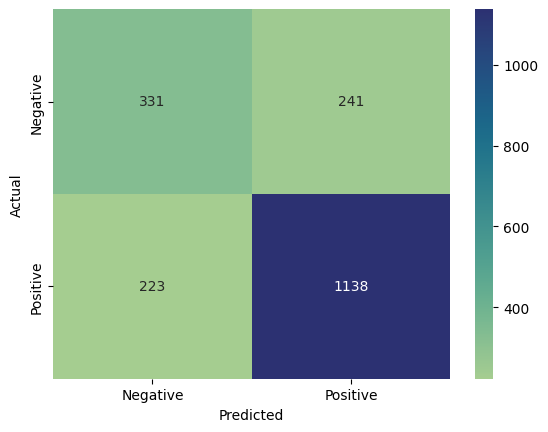

In [230]:
cluster = cluster_kmean(x_train, x_test, y_test, 'Cosine', 5, 4, 20)

In [226]:
min_dfs = range(4,8)
nodes = range(2,6)
for min_df in min_dfs:
    for node in nodes:
        print("min_df: ", min_df, "node: ", node)
        cluster = cluster_kmean(x_train, x_test, y_test, 'Cosine', min_df, node, 20)

min_df:  4 node:  2
              precision    recall  f1-score   support

           0       0.58      0.43      0.49       572
           1       0.78      0.87      0.82      1361

    accuracy                           0.74      1933
   macro avg       0.68      0.65      0.66      1933
weighted avg       0.72      0.74      0.72      1933

min_df:  4 node:  3
              precision    recall  f1-score   support

           0       0.66      0.54      0.59       572
           1       0.82      0.88      0.85      1361

    accuracy                           0.78      1933
   macro avg       0.74      0.71      0.72      1933
weighted avg       0.77      0.78      0.78      1933

min_df:  4 node:  4
              precision    recall  f1-score   support

           0       0.61      0.41      0.49       572
           1       0.78      0.89      0.83      1361

    accuracy                           0.75      1933
   macro avg       0.69      0.65      0.66      1933
weighted avg  

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       572
           1       0.70      1.00      0.83      1361

    accuracy                           0.70      1933
   macro avg       0.35      0.50      0.41      1933
weighted avg       0.50      0.70      0.58      1933

min_df:  7 node:  3
              precision    recall  f1-score   support

           0       0.55      0.47      0.51       572
           1       0.79      0.84      0.81      1361

    accuracy                           0.73      1933
   macro avg       0.67      0.65      0.66      1933
weighted avg       0.72      0.73      0.72      1933

min_df:  7 node:  4
              precision    recall  f1-score   support

           0       0.67      0.39      0.50       572
           1       0.78      0.92      0.85      1361

    accuracy                           0.76      1933
   macro avg       0.73      0.66      0.67      1933
weighted avg       0.75      0.76 

              precision    recall  f1-score   support

           0       0.56      0.45      0.50       572
           1       0.79      0.85      0.82      1361

    accuracy                           0.73      1933
   macro avg       0.67      0.65      0.66      1933
weighted avg       0.72      0.73      0.72      1933



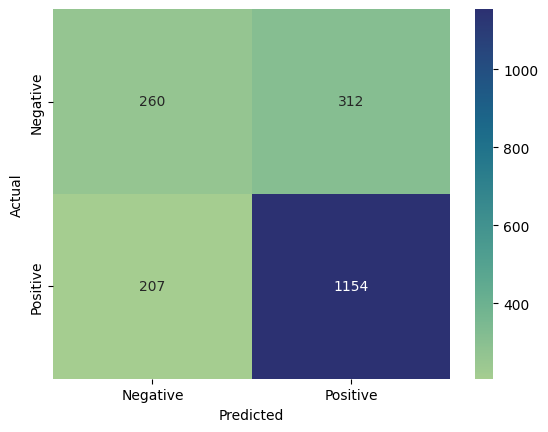

In [229]:
cluster = cluster_kmean(x_train, x_test, y_test, 'Cosine', 6, 4, 20)

              precision    recall  f1-score   support

           0       0.65      0.60      0.62       850
           1       0.84      0.87      0.85      2050

    accuracy                           0.79      2900
   macro avg       0.74      0.73      0.74      2900
weighted avg       0.78      0.79      0.79      2900



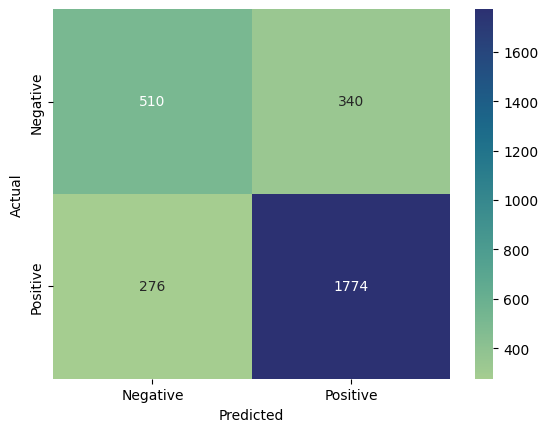

In [10]:
cluster = cluster_kmean(x_train, x_test, y_test, 'Cosine', 5, 4, 20)

In [111]:
tfidf_vect = TfidfVectorizer(stop_words=stopwords, min_df=5, binary=True)
train = tfidf_vect.fit_transform(kmean_data["review"])

clusterer = KMeansClusterer(4, cosine_distance, repeats=20)
clusters = clusterer.cluster(train.toarray(), assign_clusters=True)
predicted = [clusterer.classify(v) for v in train.toarray()]

confusion_df = pd.DataFrame(list(zip(kmean_data["sentiment_label"].values, predicted)), columns=['label', 'cluster'])
cross = pd.crosstab(index=confusion_df.cluster, columns=confusion_df.label)

              precision    recall  f1-score   support

           0       0.70      0.61      0.65      2873
           1       0.84      0.89      0.87      6792

    accuracy                           0.81      9665
   macro avg       0.77      0.75      0.76      9665
weighted avg       0.80      0.81      0.80      9665



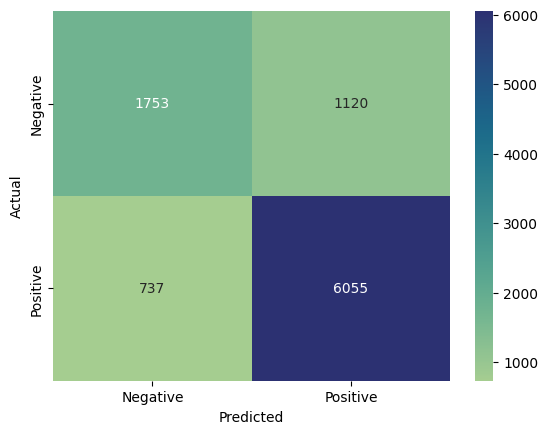

In [112]:
cluster = []
for x in predicted:
    cluster.append(cross.idxmax(axis="columns")[x])
print(classification_report(kmean_data["sentiment_label"], cluster))

definitions = ['Negative','Positive']
con_matrix = confusion_matrix(kmean_data["sentiment_label"], cluster)
sns.heatmap(con_matrix, annot=True, xticklabels=definitions, yticklabels=definitions, fmt=".0f", cmap="crest")
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
plt.show()

In [113]:
print(cluster)

[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 

In [115]:
kmean_data['Kmean_Pred'] = cluster
kmean_data.sample(10)

,review,tokenized_reviews,rating,sentiment_label,Kmean_Pred
2205,"... a bounder, and a cad! 'If you can't come u...","[, bounder, and, cad, if, you, can, not, come,...",6,1,1
4624,Toy Story is a good movie. It has good charact...,"[Toy, Story, be, good, movie, it, have, good, ...",6,1,1
84,Top Gun: Maverick is a good sequel to the orig...,"[Top, Gun, maverick, be, good, sequel, to, the...",8,1,1
5258,"Inferno (2016) might have a decent story, acti...","[Inferno, 2016, might, have, decent, story, ac...",2,0,0
5608,They say it's all in the writing. And this is ...,"[they, say, it, be, all, in, the, writing, and...",5,0,1
5516,"The producers promised us something new, and t...","[the, producer, promise, we, something, new, a...",10,1,0
702,"Yes, Enigma in 2001 was a highly fictionalized...","[yes, Enigma, in, 2001, be, highly, fictionali...",2,0,1
3592,"Having just watched this, I don't get the posi...","[having, just, watch, this, do, not, get, the,...",2,0,0
7494,Three hours of story and I had no reaction to ...,"[three, hour, of, story, and, have, no, reacti...",1,0,0
168,"Sure, this film is full of Cheddar, Red Leices...","[sure, this, film, be, full, of, Cheddar, Red,...",8,1,1


In [116]:
kmean_data.to_csv('Kmeans_Predictions.csv')

              precision    recall  f1-score   support

           0       0.63      0.73      0.68      2873
           1       0.88      0.82      0.85      6792

    accuracy                           0.79      9665
   macro avg       0.76      0.78      0.76      9665
weighted avg       0.80      0.79      0.80      9665



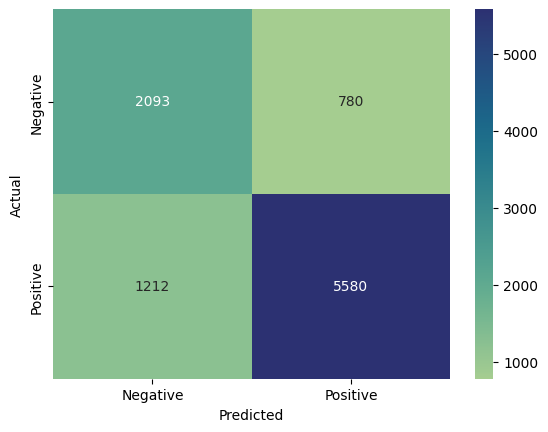

In [100]:
tfidf_vect = TfidfVectorizer(stop_words=stopwords, min_df=5, binary=True)
train = tfidf_vect.fit_transform(kmean_data["review"])

clusterer = KMeansClusterer(3, cosine_distance, repeats=20)
clusters = clusterer.cluster(train.toarray(), assign_clusters=True)
predicted = [clusterer.classify(v) for v in train.toarray()]

confusion_df = pd.DataFrame(list(zip(kmean_data["sentiment_label"].values, predicted)), columns=['label', 'cluster'])
cross = pd.crosstab(index=confusion_df.cluster, columns=confusion_df.label)

cluster = []
for x in predicted:
    cluster.append(cross.idxmax(axis="columns")[x])
print(classification_report(kmean_data["sentiment_label"], cluster))

definitions = ['Negative','Positive']
con_matrix = confusion_matrix(kmean_data["sentiment_label"], cluster)
sns.heatmap(con_matrix, annot=True, xticklabels=definitions, yticklabels=definitions, fmt=".0f", cmap="crest")
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
plt.show()

              precision    recall  f1-score   support

           0       0.71      0.28      0.40      2873
           1       0.76      0.95      0.84      6792

    accuracy                           0.75      9665
   macro avg       0.73      0.62      0.62      9665
weighted avg       0.74      0.75      0.71      9665



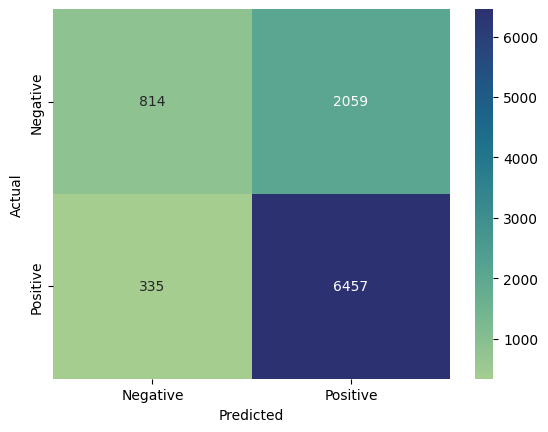

In [102]:
tfidf_vect = TfidfVectorizer(stop_words=stopwords, min_df=5, binary=True)
train = tfidf_vect.fit_transform(kmean_data["review"])

clusterer = KMeansClusterer(5, cosine_distance, repeats=20)
clusters = clusterer.cluster(train.toarray(), assign_clusters=True)
predicted = [clusterer.classify(v) for v in train.toarray()]

confusion_df = pd.DataFrame(list(zip(kmean_data["sentiment_label"].values, predicted)), columns=['label', 'cluster'])
cross = pd.crosstab(index=confusion_df.cluster, columns=confusion_df.label)

cluster = []
for x in predicted:
    cluster.append(cross.idxmax(axis="columns")[x])
print(classification_report(kmean_data["sentiment_label"], cluster))

definitions = ['Negative','Positive']
con_matrix = confusion_matrix(kmean_data["sentiment_label"], cluster)
sns.heatmap(con_matrix, annot=True, xticklabels=definitions, yticklabels=definitions, fmt=".0f", cmap="crest")
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
plt.show()